# Customer Segmentation Model (K-Means) Training and Validation

We previously generated data based on four behavioral archetypes: Thrifty, Standard, Well-off, and Techie. We will now apply Unsupervised Machine Learning to see if the algorithm can reverse-engineer these clusters based solely on transactional patterns. We will cover these four points:

* Load and Clean the Data: Load the dataset and filter the fraudulent transactions.

* Build Customer Data: Transform transaction logs into a customer-level dataset (indexed by Customer_ID).

* Train K-Means: Scale the sata and cluster customers based on behavioral similarity.

* Validate the Simulation: Compare the identified clusters against the actual profiles.

## 1. Data Loading and Cleaning


In this section, we initialize the environment and load the simulated transaction dataset. 

Unlike the Fraud Detection model (where fraud is the target), in **Customer Segmentation**, fraudulent transactions represent noise that distorts the true behavioral profile of a client. We will filter the dataset to retain **only legitimate transactions** (`Is_Fraud == 0`). This ensures that the resulting clusters reflect actual user preferences and habits, not security incidents.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
import joblib

file_path = os.path.join("..","data", "transactions_simulated.csv")
df = pd.read_csv(file_path) 

df_clean = df[df['Is_Fraud'] == 0].copy()

## 2. Feature Engineering

In this step, we transform the raw transaction logs into a customer-centric dataset (one row per unique Customer_ID). We engineered two types of features to feed the clustering algorithm:

* **Quantitative Metrics:** Capturing the intensity of the relationship (Total spend, frequency, and ticket consistency via standard deviation).

* **Qualitative Preferences (Category Pecentage):** We pivoted the spending by category and converted it into percentages. This normalization is vital to ensure the model groups customers based on their interests (e.g., "Tech Enthusiast") rather than their wallet size.The variable `Real_Profile` is preserved as a label for validation but excluded from the training data ($X$) to ensure the learning process is unsupervised.

In [3]:
# Feature Engineering and Customer Profiling
# General metrics per customer
customer_features = df_clean.groupby('Customer_ID').agg(
    Total_Spend=('Amount', 'sum'),
    Transaction_Count=('Transaction_ID', 'count'),
    Avg_Ticket=('Amount', 'mean'),
    Std_Ticket=('Amount', 'std'),
    Max_Ticket=('Amount', 'max'),
    Min_Ticket=('Amount', 'min'),
    Real_Profile=('Customer_Profile', 'first') 
)

# Customer total amount spent per category
cat_pivot = df_clean.pivot_table(
    index='Customer_ID', 
    columns='Category', 
    values='Amount', 
    aggfunc='sum', 
    fill_value=0, 
)

# Convert these amounts to percentages
cat_pct = cat_pivot.div(cat_pivot.sum(axis=1), axis=0)
cat_pct.columns = [f'Pct_{c}' for c in cat_pct.columns]

customer_data = customer_features.join(cat_pct, how='left')

# Divide features (X) from the real label (y_test)
features_cols = [c for c in customer_data.columns if c != 'Real_Profile']
X = customer_data[features_cols]
y_test = customer_data['Real_Profile']


## 3. Model Training: Pipeline Construction and Clustering

In this section, we build the unsupervised learning workflow using a Pipeline to streamline the process.
1. Standardization: We apply a StandardScaler. Since K-Means relies on Euclidean distance, this step is mandatory to prevent variables with high magnitudes (like Total Amount) from dominating variables with small ranges (like percentages).

2. K-Means Algorithm: We configure the model with $k=4$ to align with our theoretical customer profiles.

3. Model Persistence: After training, we predict the clusters for our current customers and save the entire pipeline using joblib. This saved model will be critical for the Feature Engineering phase of our future Fraud Detection model, allowing us to assign clusters to new transactions automatically.

In [4]:
# Pipeline with Scaling and K-Means
pipeline_kmeans = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=4, random_state=22))
])

# Train the pipeline
pipeline_kmeans.fit(X)

# Predict clusters
clusters = pipeline_kmeans.predict(X)

# We add the predicted clusters to the customer_data DataFrame
customer_data['Cluster_Predicted'] = clusters

# Save the pipeline as a .pkl file
os.makedirs('../models', exist_ok=True)
joblib.dump(pipeline_kmeans, '../models/pipeline_kmeans.pkl')

['../models/pipeline_kmeans.pkl']

## 4. Evaluation

### 4.1. Quantitative Assessment: The Adjusted Rand Index (ARI)

Cluster K-Means    0    1    2   3
Real Profile                      
Standard           5    0  542   0
Techie             0  111    0   0
Thrifty          259    0    6   0
Well-off           0    1    0  76


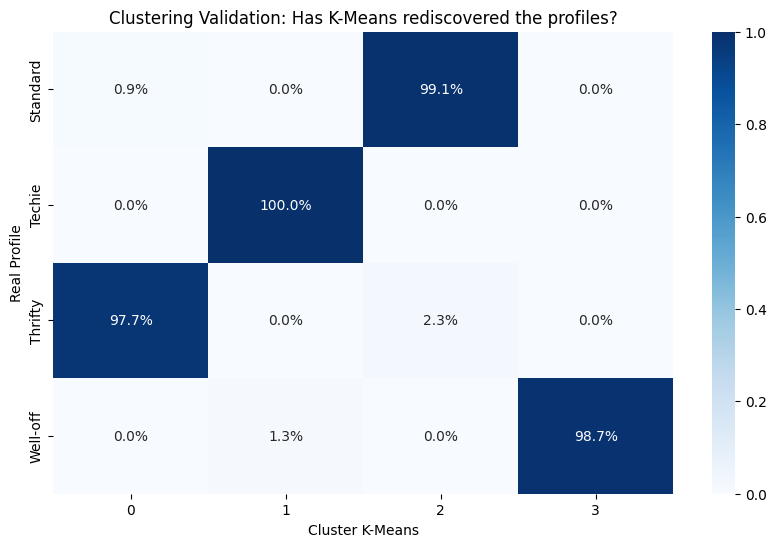

In [5]:
# Crosstable: Real Profile vs Cluster
confusion = pd.crosstab(
    customer_data['Real_Profile'], 
    customer_data['Cluster_Predicted'],
    rownames=['Real Profile'], 
    colnames=['Cluster K-Means']
    )

confusion_pct = pd.crosstab(
    customer_data['Real_Profile'], 
    customer_data['Cluster_Predicted'],
    rownames=['Real Profile'], 
    colnames=['Cluster K-Means'],
    normalize='index')

print(confusion)

# Heatmap of the confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_pct, annot=True, fmt='.1%', cmap='Blues')
plt.title('Clustering Validation: Has K-Means rediscovered the profiles?')
plt.show()

In [6]:
# Adjusted Rand Index (ARI) to evaluate clustering quality
ari = adjusted_rand_score(customer_data['Real_Profile'], customer_data['Cluster_Predicted'])
print(f"Quality of the clustering (ARI): {ari:.2f}") 

Quality of the clustering (ARI): 0.96


To evaluate the performance of our Unsupervised Learning model, we compared the predicted clusters against the ground truth (Real_Profile).

Result: We achieved an ARI of 0.96.

The Adjusted Rand Index (ARI) ranges from 0 (random guessing) to 1 (perfect match). A score of 0.96 indicates that K-Means successfully "rediscovered" the four behavioral archetypes (Thrifty, Standard, Well-off, Techie) with near-perfect accuracy, based solely on the transactional patterns.

The matrix confirms the mapping between the algorithm's output and our real profiles. We observe a minimum of 97.7% of coincidence, meaning each K-Means Cluster corresponds almost exclusively to one specific Real Profile. The minimal errors (the remaining 4%) likely represent "boundary" customers whose behavior is hybrid due to variability, for example, a Standard customer who does not pay rent.

### 4.2. Visual Assessment: PCA Dimensionality Reduction

                    Total_Spend  Transaction_Count  Avg_Ticket  Std_Ticket  \
Cluster_Predicted                                                            
0                   1038.011894          14.208333   74.781828  129.047286   
1                  20747.204375          63.392857  327.732087  330.942922   
2                   3252.492573          37.063869   87.762434  114.970709   
3                  27209.443816          71.657895  380.366301  365.965583   

                    Max_Ticket  Min_Ticket  Pct_Groceries  Pct_Housing  \
Cluster_Predicted                                                        
0                   503.883598   10.615189       0.337492     0.412767   
1                  1220.930179   29.774286       0.044368     0.042021   
2                   724.992245   16.511825       0.263555     0.201510   
3                  2802.096053   72.145000       0.075584     0.090703   

                   Pct_Leisure  Pct_Others  Pct_Retail  Pct_Transportation  \
Cluster_

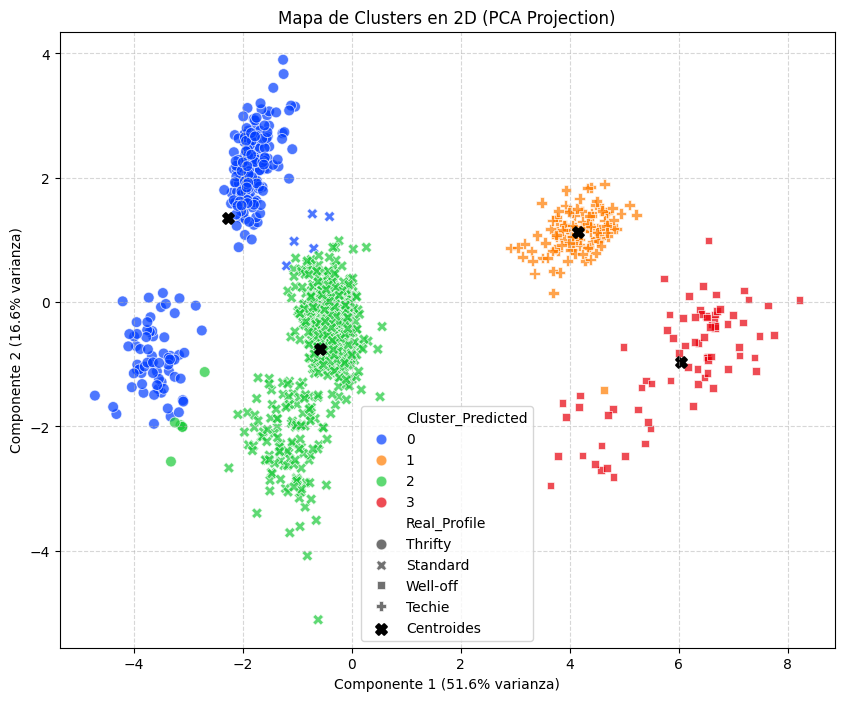

In [7]:
cluster_summary = customer_data.groupby('Cluster_Predicted')[features_cols].mean()

print(cluster_summary[features_cols])

df_scaled = pipeline_kmeans['scaler'].transform(customer_data[features_cols])

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)

# 2. CREAR DATAFRAME CON LOS RESULTADOS
# Creamos un DF temporal con PC1, PC2 y el Cluster asignado
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster_Predicted'] = clusters 
pca_df['Real_Profile'] = customer_data['Real_Profile'].values

# 3. VISUALIZACIÓN
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue='Cluster_Predicted', 
    style='Real_Profile',
    palette='bright', 
    data=pca_df,
    s=60,           # Tamaño de los puntos
    alpha=0.7,      # Transparencia para ver superposiciones
    edgecolor='w'   # Borde blanco para que se vean mejor
)

# (Opcional) Pintar los CENTROIDES en el mapa PCA
# Agrupamos por cluster y calculamos la media de PC1 y PC2
centroids_pca = pca_df.groupby('Cluster_Predicted')[['PC1', 'PC2']].mean()
plt.scatter(centroids_pca['PC1'], centroids_pca['PC2'], 
            marker='X', s=60, linewidths=1.5, color='black', label='Centroides')

plt.title('Mapa de Clusters en 2D (PCA Projection)')
plt.xlabel(f'Componente 1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
plt.ylabel(f'Componente 2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Since we cannot visualize a dataset with multiple features (Dimensions) directly, we used Principal Component Analysis (PCA) to project the data into a 2D space.

Cluster Separation: The scatter plot demonstrates clear, distinct "islands" of data. The lack of significant overlap between the colored groups visually confirms that our features (Spending Ratios, Frequency, Ticket Size) provide strong signals that differentiate the customer segments.

Consistency: The shape of the clusters (Ground Truth) matches the colors (K-Means Predictions), reinforcing the ARI score visually.